## Photons list

In [2]:
from pathlib import Path
from astropy.io import fits
import pandas as pd
import numpy as np

In [3]:
from RTAscience.cfg.Config import Config

In [4]:
datapath = Path("/data01/home/baroncelli/phd/DATA")
simFolder = datapath.joinpath("obs/obs_st_grb_tr_1_os_1800_emin_0.03_emax_0.15_roi_2.5")
cfg = Config(simFolder.joinpath("config.yaml"))
runid = cfg.get('runid')

In [5]:
if cfg.get("simtype") == 'bkg':
    inputFitsFile = simFolder.joinpath("backgrounds","bkg000001.fits")
else:
    inputFitsFile = simFolder.joinpath(runid,"ebl000001.fits")    

In [6]:
hdul = fits.open(inputFitsFile)
hdul.info()

Filename: /data01/home/baroncelli/phd/DATA/obs/obs_st_grb_tr_1_os_1800_emin_0.03_emax_0.15_roi_2.5/run0406_ID000126/ebl000001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  EVENTS        1 BinTableHDU     78   420610R x 8C   [J, D, E, E, E, E, E, J]   
  2  GTI           1 BinTableHDU     18   1R x 2C   [1D, 1D]   


In [7]:
hdul[1].columns.names

['EVENT_ID', 'TIME', 'RA', 'DEC', 'ENERGY', 'DETX', 'DETY', 'MC_ID']

In [8]:
hdul[1].data

FITS_rec([(          1, 3.73130441e-02, 34.112865, -51.12713 , 0.03249727,  0.70908594,  0.6626505, 1),
          (          2, 4.39919233e-02, 30.936813, -52.20182 , 0.04408681, -0.37975574, -1.299248 , 1),
          (          3, 5.07707596e-02, 34.400654, -52.640884, 0.03221962, -0.80742764,  0.8153203, 1),
          ...,
          (     349334, 3.59995861e+03, 30.664282, -50.977493, 0.03731393,  0.83887094, -1.5063064, 1),
          (     349335, 3.59996993e+03, 35.983788, -51.219227, 0.03816205,  0.58506465,  1.8327191, 1),
          (     349336, 3.59998903e+03, 33.88144 , -51.58115 , 0.03757417,  0.25695333,  0.512302 , 1)],
         dtype=(numpy.record, [('EVENT_ID', '>i4'), ('TIME', '>f8'), ('RA', '>f4'), ('DEC', '>f4'), ('ENERGY', '>f4'), ('DETX', '>f4'), ('DETY', '>f4'), ('MC_ID', '>i4')]))

## From Fits to Dataframe
Byte-ordering issues: https://pandas.pydata.org/pandas-docs/stable/user_guide/gotchas.html#byte-ordering-issues

In [9]:
events = pd.DataFrame(columns=hdul[1].columns.names)

In [10]:
for colname in events.columns:
    events[colname] = hdul[1].data[colname].byteswap().newbyteorder()

In [11]:
del events['MC_ID']
del events['EVENT_ID']

In [12]:
events.head()

,TIME,RA,DEC,ENERGY,DETX,DETY
0,0.037313,34.112865,-51.127129,0.032497,0.709086,0.662651
1,0.043992,30.936813,-52.201820,0.044087,-0.379756,-1.299248
2,0.050771,34.400654,-52.640884,0.032220,-0.807428,0.815320
3,0.055986,35.434982,-51.465843,0.058451,0.351027,1.481186
4,0.059351,31.984726,-51.714741,0.038960,0.121372,-0.664334


## Feature engineering

TD (time difference): each sample has the td feature: the number of seconds before the last event 

In [13]:
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt

In [14]:
events["TD"] = events["TIME"][0:] - events["TIME"][0:].shift()
events.iloc[0, 6] = 0 # TD value of first sample is 0
events.head(5)

,TIME,RA,DEC,ENERGY,DETX,DETY,TD
0,0.037313,34.112865,-51.127129,0.032497,0.709086,0.662651,0.000000
1,0.043992,30.936813,-52.201820,0.044087,-0.379756,-1.299248,0.006679
2,0.050771,34.400654,-52.640884,0.032220,-0.807428,0.815320,0.006779
3,0.055986,35.434982,-51.465843,0.058451,0.351027,1.481186,0.005216
4,0.059351,31.984726,-51.714741,0.038960,0.121372,-0.664334,0.003365


<AxesSubplot:>

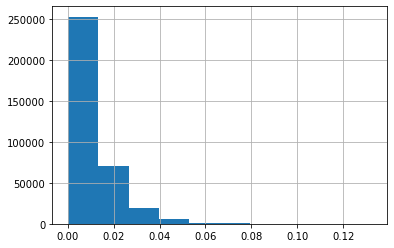

In [20]:
events["TD"][0:].hist()

### No integration

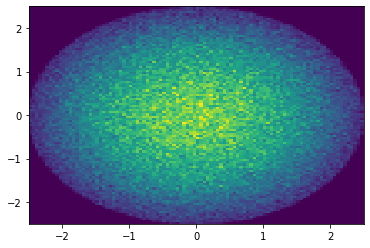

In [174]:
_ = plt.hist2d(x=events["DETX"], y=events["DETY"], bins=100)

<AxesSubplot:>

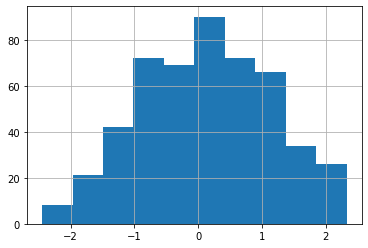

In [21]:
events["DETX"][0:500].hist()

<AxesSubplot:>

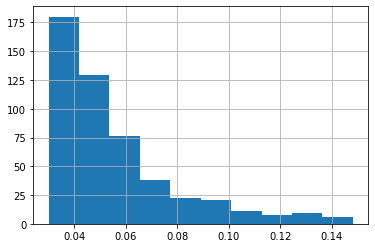

In [19]:
events["ENERGY"][0:500].hist()

In [158]:
events.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
TIME,349336.0,1800.160152,1039.797864,0.037313,897.791171,1798.371305,2701.656912,3599.989028
RA,349336.0,33.051067,1.744243,29.010452,31.734685,33.047894,34.367928,37.104603
DEC,349336.0,-51.828812,1.075558,-54.338367,-52.639106,-51.826580,-51.015687,-49.341675
ENERGY,349336.0,0.056830,0.025265,0.030000,0.038800,0.048064,0.066840,0.149997
DETX,349336.0,-0.000715,1.075737,-2.497375,-0.813335,-0.001383,0.811048,2.499305
DETY,349336.0,-0.003615,1.077339,-2.497906,-0.816529,-0.005691,0.809884,2.497838
TD,349336.0,0.010305,0.010298,0.000000,0.002965,0.007139,0.014295,0.132545


### Space/Time/Energy integration


In [11]:
from astro.lib.photometry import Photometrics
from RTAscience.lib.RTAUtils import get_pointing

#### Space

In [86]:
radius = 2.5

#### Time

In [87]:
t_bin_size = 10
t_shift = 10

#### Energy

In [88]:
e_bin_size = 0.01
e_shift = 0.01 # TeV

In [89]:
def get_bins(start, stop, binsize, shift):
    time_windows = []
    t_start = start
    t_stop = stop
    w_start = start
    while w_start + binsize < t_stop:
        time_windows.append( (round(w_start, 3), round(w_start + binsize, 3))  )
        w_start += shift
    return time_windows

In [90]:
time_bins = get_bins(0, cfg.get('tobs'), t_bin_size, t_shift)
print(f"Number of windows: {len(time_bins)} Example: {time_bins[0:5]}")

Number of windows: 359 Example: [(0, 10), (10, 20), (20, 30), (30, 40), (40, 50)]


In [94]:
energy_bins = get_bins(cfg.get('emin'), cfg.get('emax'), e_bin_size, e_shift)
print(f"Number of windows: {len(energy_bins)}. Examples: {energy_bins[0:5]}")

Number of windows: 11. Examples: [(0.03, 0.04), (0.04, 0.05), (0.05, 0.06), (0.06, 0.07), (0.07, 0.08)]


In [ ]:
pd.DataFrame(columns=["counts"] )

In [80]:
phm = Photometrics({ 'events_filename': inputFitsFile })
region = {
    'ra': get_pointing(datapath.joinpath(f'templates/{runid}.fits'))[0],
    'dec': get_pointing(datapath.joinpath(f'templates/{runid}.fits'))[1],
}

for time_bin in time_bins:
    for energy_bin in energy_bins:
        region_count = phm.region_counter(region, radius, tmin=time_bin[0], tmax=time_bin[1], emin=energy_bin[0], emax=energy_bin[1])
        print(f"{time_bin} - {energy_bin}: {region_count}")

(0, 10) - (0.03, 0.05): 516
(0, 10) - (0.05, 0.07): 218
(0, 10) - (0.07, 0.09): 100
(0, 10) - (0.09, 0.11): 49
(0, 10) - (0.11, 0.13): 35
(10, 20) - (0.03, 0.05): 545
(10, 20) - (0.05, 0.07): 219
(10, 20) - (0.07, 0.09): 100
(10, 20) - (0.09, 0.11): 55
(10, 20) - (0.11, 0.13): 25
(20, 30) - (0.03, 0.05): 543
(20, 30) - (0.05, 0.07): 218
(20, 30) - (0.07, 0.09): 102
(20, 30) - (0.09, 0.11): 62
(20, 30) - (0.11, 0.13): 34
(30, 40) - (0.03, 0.05): 523
(30, 40) - (0.05, 0.07): 209
(30, 40) - (0.07, 0.09): 110
(30, 40) - (0.09, 0.11): 64
(30, 40) - (0.11, 0.13): 36
(40, 50) - (0.03, 0.05): 542
(40, 50) - (0.05, 0.07): 204
(40, 50) - (0.07, 0.09): 118
(40, 50) - (0.09, 0.11): 53
(40, 50) - (0.11, 0.13): 38
(50, 60) - (0.03, 0.05): 545
(50, 60) - (0.05, 0.07): 229
(50, 60) - (0.07, 0.09): 99
(50, 60) - (0.09, 0.11): 46
(50, 60) - (0.11, 0.13): 39
(60, 70) - (0.03, 0.05): 498
(60, 70) - (0.05, 0.07): 200
(60, 70) - (0.07, 0.09): 107
(60, 70) - (0.09, 0.11): 51
(60, 70) - (0.11, 0.13): 21
(70, 

(540, 550) - (0.11, 0.13): 35
(550, 560) - (0.03, 0.05): 496
(550, 560) - (0.05, 0.07): 259
(550, 560) - (0.07, 0.09): 112
(550, 560) - (0.09, 0.11): 47
(550, 560) - (0.11, 0.13): 34
(560, 570) - (0.03, 0.05): 529
(560, 570) - (0.05, 0.07): 207
(560, 570) - (0.07, 0.09): 102
(560, 570) - (0.09, 0.11): 72
(560, 570) - (0.11, 0.13): 34
(570, 580) - (0.03, 0.05): 458
(570, 580) - (0.05, 0.07): 233
(570, 580) - (0.07, 0.09): 95
(570, 580) - (0.09, 0.11): 66
(570, 580) - (0.11, 0.13): 35
(580, 590) - (0.03, 0.05): 524
(580, 590) - (0.05, 0.07): 233
(580, 590) - (0.07, 0.09): 114
(580, 590) - (0.09, 0.11): 42
(580, 590) - (0.11, 0.13): 28
(590, 600) - (0.03, 0.05): 528
(590, 600) - (0.05, 0.07): 252
(590, 600) - (0.07, 0.09): 99
(590, 600) - (0.09, 0.11): 59
(590, 600) - (0.11, 0.13): 44
(600, 610) - (0.03, 0.05): 553
(600, 610) - (0.05, 0.07): 240
(600, 610) - (0.07, 0.09): 96
(600, 610) - (0.09, 0.11): 51
(600, 610) - (0.11, 0.13): 27
(610, 620) - (0.03, 0.05): 512
(610, 620) - (0.05, 0.07

(1100, 1110) - (0.05, 0.07): 227
(1100, 1110) - (0.07, 0.09): 117
(1100, 1110) - (0.09, 0.11): 55
(1100, 1110) - (0.11, 0.13): 25
(1110, 1120) - (0.03, 0.05): 491
(1110, 1120) - (0.05, 0.07): 229
(1110, 1120) - (0.07, 0.09): 118
(1110, 1120) - (0.09, 0.11): 55
(1110, 1120) - (0.11, 0.13): 30
(1120, 1130) - (0.03, 0.05): 513
(1120, 1130) - (0.05, 0.07): 231
(1120, 1130) - (0.07, 0.09): 103
(1120, 1130) - (0.09, 0.11): 61
(1120, 1130) - (0.11, 0.13): 46
(1130, 1140) - (0.03, 0.05): 528
(1130, 1140) - (0.05, 0.07): 217
(1130, 1140) - (0.07, 0.09): 108
(1130, 1140) - (0.09, 0.11): 50
(1130, 1140) - (0.11, 0.13): 32
(1140, 1150) - (0.03, 0.05): 525
(1140, 1150) - (0.05, 0.07): 202
(1140, 1150) - (0.07, 0.09): 112
(1140, 1150) - (0.09, 0.11): 60
(1140, 1150) - (0.11, 0.13): 32
(1150, 1160) - (0.03, 0.05): 467
(1150, 1160) - (0.05, 0.07): 235
(1150, 1160) - (0.07, 0.09): 109
(1150, 1160) - (0.09, 0.11): 48
(1150, 1160) - (0.11, 0.13): 32
(1160, 1170) - (0.03, 0.05): 515
(1160, 1170) - (0.05, 

(1630, 1640) - (0.11, 0.13): 30
(1640, 1650) - (0.03, 0.05): 527
(1640, 1650) - (0.05, 0.07): 258
(1640, 1650) - (0.07, 0.09): 95
(1640, 1650) - (0.09, 0.11): 52
(1640, 1650) - (0.11, 0.13): 31
(1650, 1660) - (0.03, 0.05): 519
(1650, 1660) - (0.05, 0.07): 234
(1650, 1660) - (0.07, 0.09): 111
(1650, 1660) - (0.09, 0.11): 45
(1650, 1660) - (0.11, 0.13): 37
(1660, 1670) - (0.03, 0.05): 480
(1660, 1670) - (0.05, 0.07): 251
(1660, 1670) - (0.07, 0.09): 97
(1660, 1670) - (0.09, 0.11): 49
(1660, 1670) - (0.11, 0.13): 31
(1670, 1680) - (0.03, 0.05): 509
(1670, 1680) - (0.05, 0.07): 207
(1670, 1680) - (0.07, 0.09): 113
(1670, 1680) - (0.09, 0.11): 61
(1670, 1680) - (0.11, 0.13): 23
(1680, 1690) - (0.03, 0.05): 501
(1680, 1690) - (0.05, 0.07): 250
(1680, 1690) - (0.07, 0.09): 99
(1680, 1690) - (0.09, 0.11): 63
(1680, 1690) - (0.11, 0.13): 28
(1690, 1700) - (0.03, 0.05): 536
(1690, 1700) - (0.05, 0.07): 194
(1690, 1700) - (0.07, 0.09): 92
(1690, 1700) - (0.09, 0.11): 57
(1690, 1700) - (0.11, 0.13

(2170, 2180) - (0.11, 0.13): 30
(2180, 2190) - (0.03, 0.05): 567
(2180, 2190) - (0.05, 0.07): 218
(2180, 2190) - (0.07, 0.09): 95
(2180, 2190) - (0.09, 0.11): 59
(2180, 2190) - (0.11, 0.13): 42
(2190, 2200) - (0.03, 0.05): 560
(2190, 2200) - (0.05, 0.07): 235
(2190, 2200) - (0.07, 0.09): 94
(2190, 2200) - (0.09, 0.11): 49
(2190, 2200) - (0.11, 0.13): 26
(2200, 2210) - (0.03, 0.05): 513
(2200, 2210) - (0.05, 0.07): 252
(2200, 2210) - (0.07, 0.09): 125
(2200, 2210) - (0.09, 0.11): 61
(2200, 2210) - (0.11, 0.13): 39
(2210, 2220) - (0.03, 0.05): 516
(2210, 2220) - (0.05, 0.07): 229
(2210, 2220) - (0.07, 0.09): 94
(2210, 2220) - (0.09, 0.11): 46
(2210, 2220) - (0.11, 0.13): 41
(2220, 2230) - (0.03, 0.05): 522
(2220, 2230) - (0.05, 0.07): 237
(2220, 2230) - (0.07, 0.09): 102
(2220, 2230) - (0.09, 0.11): 68
(2220, 2230) - (0.11, 0.13): 30
(2230, 2240) - (0.03, 0.05): 539
(2230, 2240) - (0.05, 0.07): 238
(2230, 2240) - (0.07, 0.09): 104
(2230, 2240) - (0.09, 0.11): 61
(2230, 2240) - (0.11, 0.1

(2710, 2720) - (0.07, 0.09): 91
(2710, 2720) - (0.09, 0.11): 57
(2710, 2720) - (0.11, 0.13): 45
(2720, 2730) - (0.03, 0.05): 455
(2720, 2730) - (0.05, 0.07): 240
(2720, 2730) - (0.07, 0.09): 110
(2720, 2730) - (0.09, 0.11): 67
(2720, 2730) - (0.11, 0.13): 38
(2730, 2740) - (0.03, 0.05): 531
(2730, 2740) - (0.05, 0.07): 227
(2730, 2740) - (0.07, 0.09): 97
(2730, 2740) - (0.09, 0.11): 73
(2730, 2740) - (0.11, 0.13): 27
(2740, 2750) - (0.03, 0.05): 533
(2740, 2750) - (0.05, 0.07): 237
(2740, 2750) - (0.07, 0.09): 118
(2740, 2750) - (0.09, 0.11): 57
(2740, 2750) - (0.11, 0.13): 28
(2750, 2760) - (0.03, 0.05): 551
(2750, 2760) - (0.05, 0.07): 201
(2750, 2760) - (0.07, 0.09): 112
(2750, 2760) - (0.09, 0.11): 52
(2750, 2760) - (0.11, 0.13): 29
(2760, 2770) - (0.03, 0.05): 517
(2760, 2770) - (0.05, 0.07): 247
(2760, 2770) - (0.07, 0.09): 116
(2760, 2770) - (0.09, 0.11): 67
(2760, 2770) - (0.11, 0.13): 29
(2770, 2780) - (0.03, 0.05): 521
(2770, 2780) - (0.05, 0.07): 220
(2770, 2780) - (0.07, 0.

(3220, 3230) - (0.03, 0.05): 494
(3220, 3230) - (0.05, 0.07): 236
(3220, 3230) - (0.07, 0.09): 97
(3220, 3230) - (0.09, 0.11): 65
(3220, 3230) - (0.11, 0.13): 29
(3230, 3240) - (0.03, 0.05): 516
(3230, 3240) - (0.05, 0.07): 253
(3230, 3240) - (0.07, 0.09): 109
(3230, 3240) - (0.09, 0.11): 58
(3230, 3240) - (0.11, 0.13): 34
(3240, 3250) - (0.03, 0.05): 540
(3240, 3250) - (0.05, 0.07): 249
(3240, 3250) - (0.07, 0.09): 108
(3240, 3250) - (0.09, 0.11): 55
(3240, 3250) - (0.11, 0.13): 20
(3250, 3260) - (0.03, 0.05): 548
(3250, 3260) - (0.05, 0.07): 232
(3250, 3260) - (0.07, 0.09): 118
(3250, 3260) - (0.09, 0.11): 56
(3250, 3260) - (0.11, 0.13): 42
(3260, 3270) - (0.03, 0.05): 504
(3260, 3270) - (0.05, 0.07): 216
(3260, 3270) - (0.07, 0.09): 92
(3260, 3270) - (0.09, 0.11): 57
(3260, 3270) - (0.11, 0.13): 34
(3270, 3280) - (0.03, 0.05): 555
(3270, 3280) - (0.05, 0.07): 239
(3270, 3280) - (0.07, 0.09): 119
(3270, 3280) - (0.09, 0.11): 54
(3270, 3280) - (0.11, 0.13): 35
(3280, 3290) - (0.03, 0.